# Analysis of fate commitment predictors

In this tutorial, we're going to analyse the dataset from the first tutorial to identify early markers of fate commitments in clones.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sclitr as sl

sc.set_figure_params(dpi=80)
sns.set_style("ticks")

We're going to work with `adata` and `clones` objects that we generated in the first tutorial.

In [2]:
adata = sc.read_h5ad("Weinreb_GEX.h5ad")
clones = sc.read_h5ad("Weinreb_clones.h5ad")

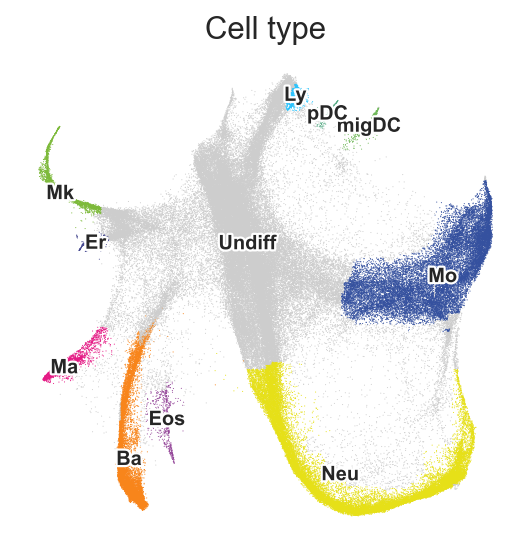

In [12]:
sc.pl.embedding(
    adata,
    basis="X_spring",
    color="Cell type annotation short",
    frameon=False,
    title="Cell type",
    legend_loc="on data",
    legend_fontsize=9,
    legend_fontoutline=2,
)

### clone2vec model

In this part, we will predict clone2vec embedding position based on pseudobulked expression in the undifferentiated cells.

> **⚠️ Note on interpreting SHAP values**
>
> SHAP values indicate how much each gene contributes to the model’s prediction, not how strongly it is correlated with the outcome. For example, if two genes are both highly correlated with the predicted outcome, but one of them (say, gene A) already captures most of the predictive signal, the model may rely less on the second one (gene B). As a result, Gene B might end up with a low SHAP value — not because it’s unimportant biologically, but because the model doesn’t need it to make accurate predictions. This means SHAP values reflect the model’s logic and feature dependencies, which may differ from simple correlation or statistical association.

In [ ]:
shapdata_c2v = sl.tl.predict_c2v(
    adata,
    clones,
    clone_col="Clone",
    ct_col="Cell type annotation short",
    use_gpu=True,
    verbose=False,
    limit_ct="Undiff",
    use_ct=False,
    pseudobulk=True,
)

/home/sergey/tools/scLiTr/sclitr/utils.py:239: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr = expr.groupby(["celltype_column", "clone_column"]).mean().reset_index().dropna()


In [168]:
shapdata_c2v.var["average_shap"] = shapdata_c2v.layers["shap"].mean(axis=0).A[0]
shapdata_c2v.var["average_shap_normalized"] = shapdata_c2v.var["average_shap"] / shapdata_c2v.var["average_shap"].max()

shapdata_c2v.var.sort_values("average_shap", ascending=False).head(10)

,average_shap,average_shap_normalized
Gata2,0.926854,1.000000
Cybb,0.514548,0.555156
Gstm1,0.487884,0.526387
Srgn,0.423000,0.456383
Dlk1,0.422736,0.456098
Mpo,0.372446,0.401839
H2afy,0.332851,0.359120
Cyp11a1,0.311270,0.335835
Ly6a,0.268847,0.290064
Elane,0.262757,0.283493


We can visually examine the perfomance of the model on the clones from validation set. Perfomance on a validation set can show us if the model overfitted.

> **Note on assessing model quality**
> 
> In a standard machine learning workflow, the data is ideally split into three sets: training (for learning model parameters), validation (for tuning hyperparameters), and test (for final performance evaluation). In our case, we use only training and validation sets for two main reasons: (a) the dataset is relatively small, and (b) the validation set is used solely for monitoring overfitting during training, not for selecting the final model. While this setup doesn't allow for a completely unbiased performance estimate, it is a practical compromise given the limited data.

In [183]:
clones_predicted = clones.copy()

clones_predicted = clones_predicted[clones.uns["clone2vec_predicted_names"]]
clones_predicted.obsm["clone2vec"] = clones_predicted.uns["clone2vec_predicted"].copy()
clones_predicted = clones_predicted[clones_predicted.obs.eval_set == "validation"].copy()

sc.pp.neighbors(clones_predicted, use_rep="clone2vec", n_neighbors=15)
sc.tl.umap(clones_predicted)

In [184]:
# Constructing UMAP based on real coordinates of validation clones only
clones_validation = clones[clones.obs.eval_set == "validation"].copy()

sc.pp.neighbors(clones_validation, use_rep="clone2vec", n_neighbors=15)
sc.tl.umap(clones_validation)

<Axes: title={'center': 'UMAP on real clone2vec'}, xlabel='UMAP1', ylabel='UMAP2'>

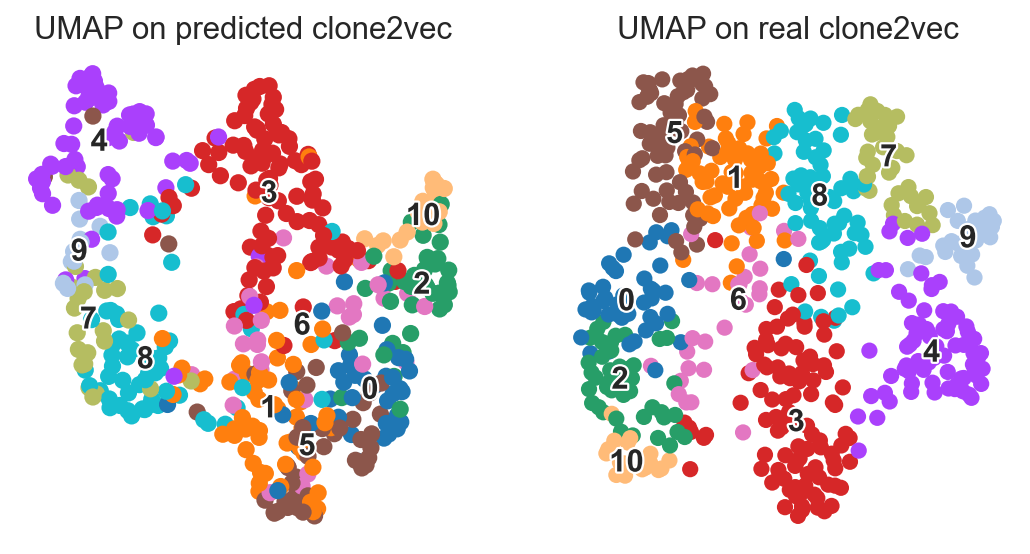

In [185]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

sc.pl.umap(clones_predicted, ax=axes[0], show=False, frameon=False, legend_fontoutline=2,
           title="UMAP on predicted clone2vec", color="leiden", legend_loc="on data")

sc.pl.umap(clones_validation, ax=axes[1], show=False, frameon=False, title="UMAP on real clone2vec",
           legend_fontoutline=2, color="leiden", legend_loc="on data")

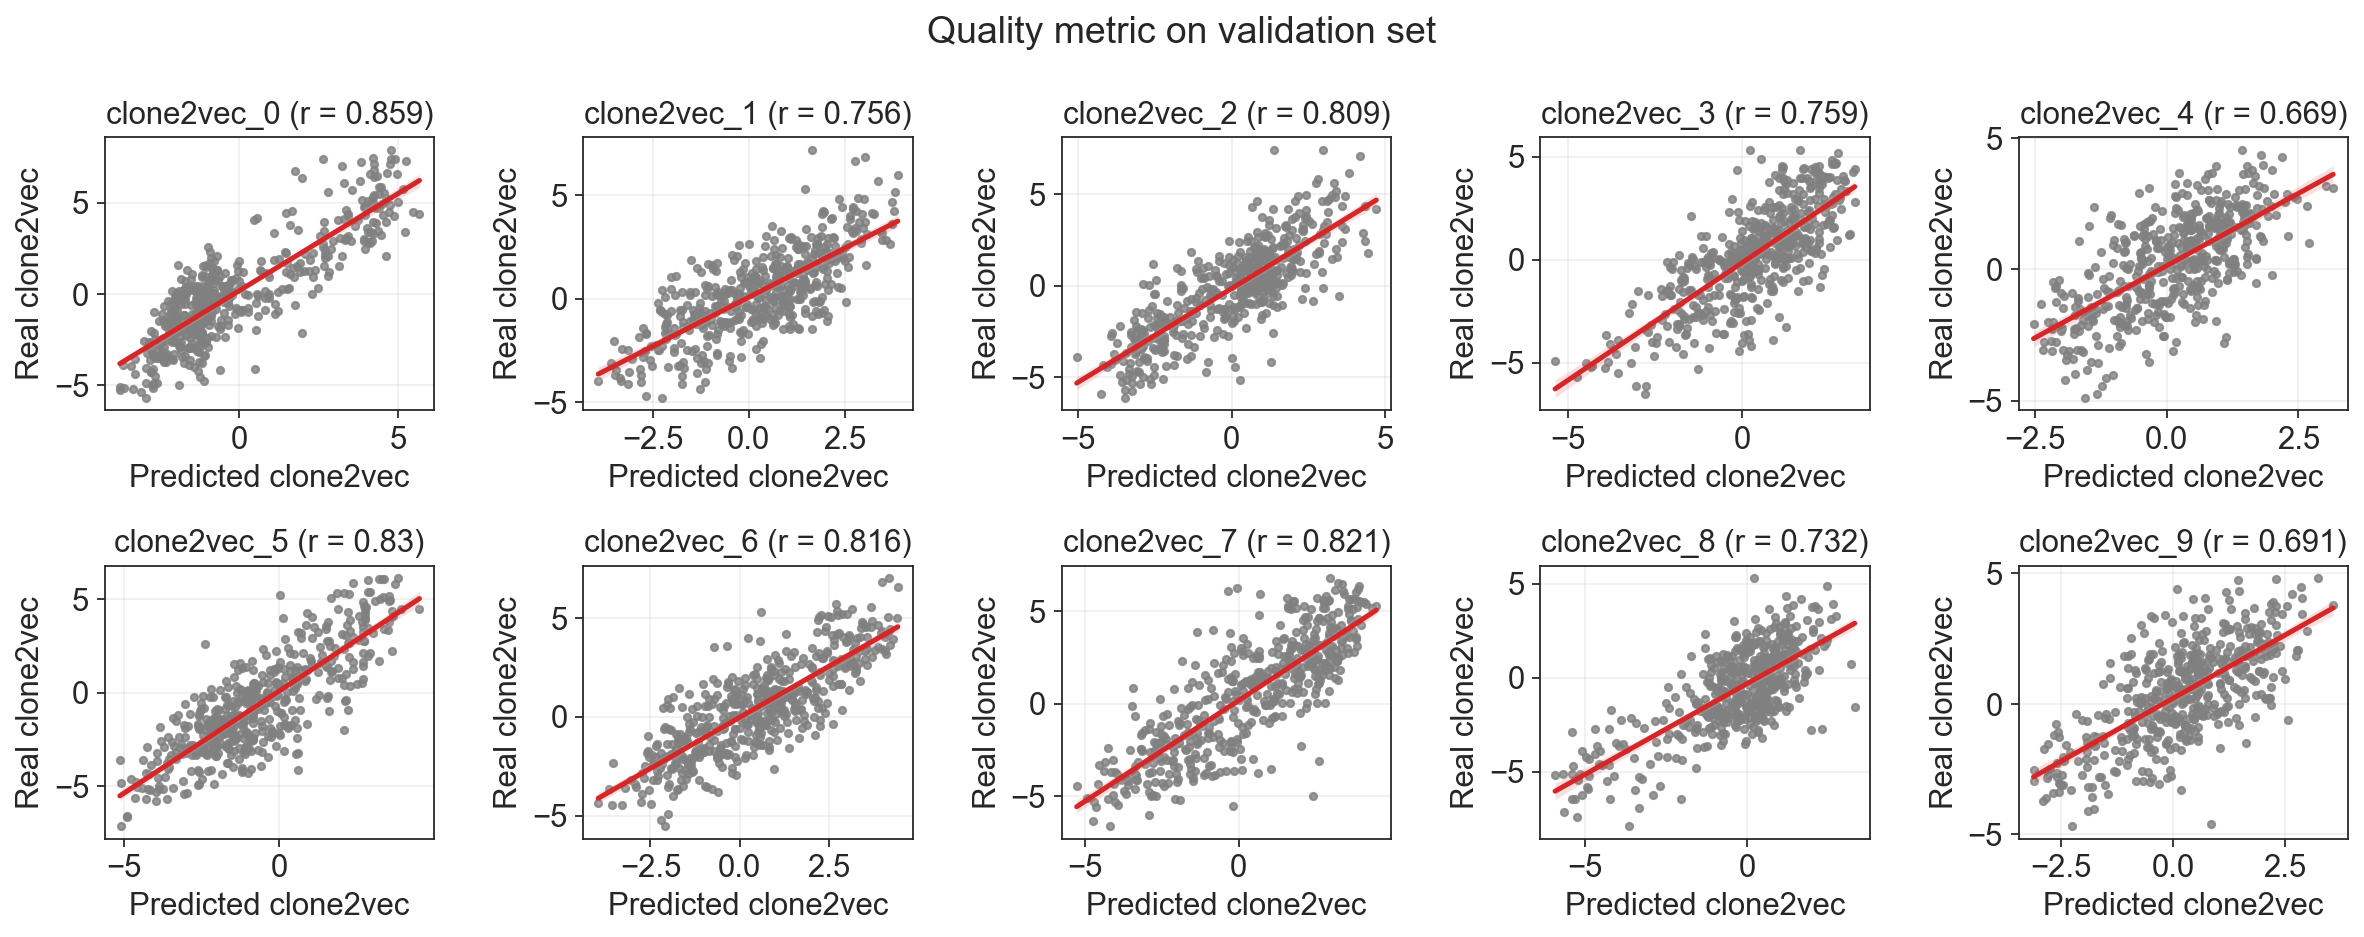

In [186]:
from scipy.stats import pearsonr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

col = 0
row = 0

common_clones = clones_predicted.obs_names[
    clones_predicted.obs_names.isin(clones_validation.obs_names)
]

for i in range(10):
    ax = axes[row, col]
    
    sns.regplot(
        x=clones_predicted[common_clones].obsm["clone2vec"][:, i],
        y=clones_validation[common_clones].obsm["clone2vec"][:, i],
        scatter_kws={"s": 10, "color": "grey"},
        line_kws={"color": sns.color_palette()[3]},
        ax = ax,
    )

    ax.grid(alpha=0.3)
    ax.set_xlabel("Predicted clone2vec")
    ax.set_ylabel("Real clone2vec")

    r = np.round(pearsonr(
        clones_predicted[common_clones].obsm["clone2vec"][:, i],
        clones_validation[common_clones].obsm["clone2vec"][:, i],
    ).statistic, 3)
    ax.set_title(f"clone2vec_{i} (r = {r})")
    
    col += 1
    if col == 5:
        col = 0
        row = 1
        
plt.suptitle("Quality metric on validation set")
plt.tight_layout()

### Cell type model

Here we will create an independent model aiming to predict cell type proportions in each clone based on the expression in undifferentiated cells. Such models usually perform overall not so good, as clone2vec models, but they can help to annotate each gene from the clone2vec model.

In [60]:
shapdata_ct = sl.tl.predict_ct(
    adata,
    clones,
    clone_col="Clone",
    ct_col="Cell type annotation short",
    use_gpu=True,
    verbose=False,
    limit_ct="Undiff",
    use_ct=False,
    pseudobulk=True,
    ct_layer="frequencies",
)

/home/sergey/tools/scLiTr/sclitr/utils.py:239: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr = expr.groupby(["celltype_column", "clone_column"]).mean().reset_index().dropna()


Some of the clones doesn't contain cell type of interest. Putting the result of prediction in the uns.


In [170]:
shapdata_ct.var["average_shap"] = shapdata_ct.layers["shap"].mean(axis=0).A[0]
shapdata_ct.var.sort_values("average_shap", ascending=False)["average_shap"].head(10)

Cpa3       0.457509
Gata2      0.434112
Elane      0.418330
Ly6a       0.339789
Cybb       0.283634
Gstm1      0.270601
Cyp11a1    0.259496
Ifi203     0.221494
Mpo        0.207748
Dlk1       0.204275
Name: average_shap, dtype: float64

We can also visually inspect the quality of the prediction on the validation set.

In [188]:
clones_predicted = clones.copy()

clones_predicted = clones_predicted[clones.uns["ct_predicted_names"]]
clones_predicted.layers["frequencies_predicted"] = clones_predicted.uns["ct_predicted"].copy()
clones_predicted = clones_predicted[clones_predicted.obs.eval_set == "validation"].copy()

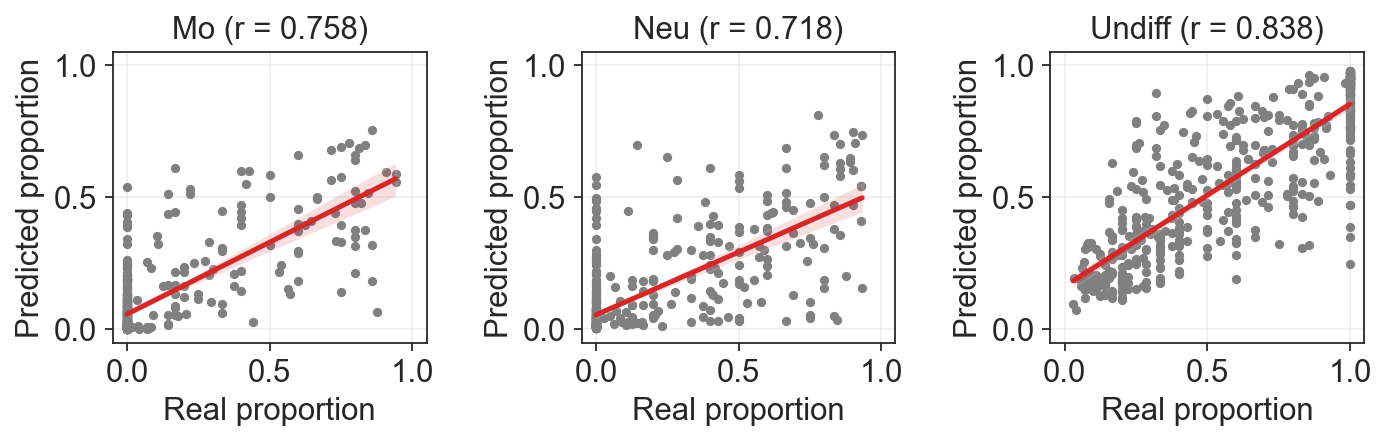

In [192]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3))

for i, ct in enumerate(["Mo", "Neu", "Undiff"]):
    ax = axes[i]
    
    sns.regplot(
        x=clones_predicted[:, ct].layers["frequencies"].T[0],
        y=clones_predicted[:, ct].layers["frequencies_predicted"].T[0],
        scatter_kws={"alpha": 1, "color": "grey", "s": 10},
        line_kws={"color": sns.color_palette()[3]},
        ax=ax,
    )

    ax.set_xlabel("Real proportion")
    ax.set_ylabel("Predicted proportion")
    ax.grid(alpha=0.3)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    
    r = np.round(pearsonr(
        clones_predicted[:, ct].layers["frequencies"].T[0],
        clones_predicted[:, ct].layers["frequencies_predicted"].T[0],
    ).statistic, 3)
    ax.set_title(f"{ct} (r = {r})")
    
plt.tight_layout()

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = ax.transData.transform((x[i], y[i]))
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = ax.transData.transform((x[i], y[i]))
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/textalloc/__init__.py:530: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To ac

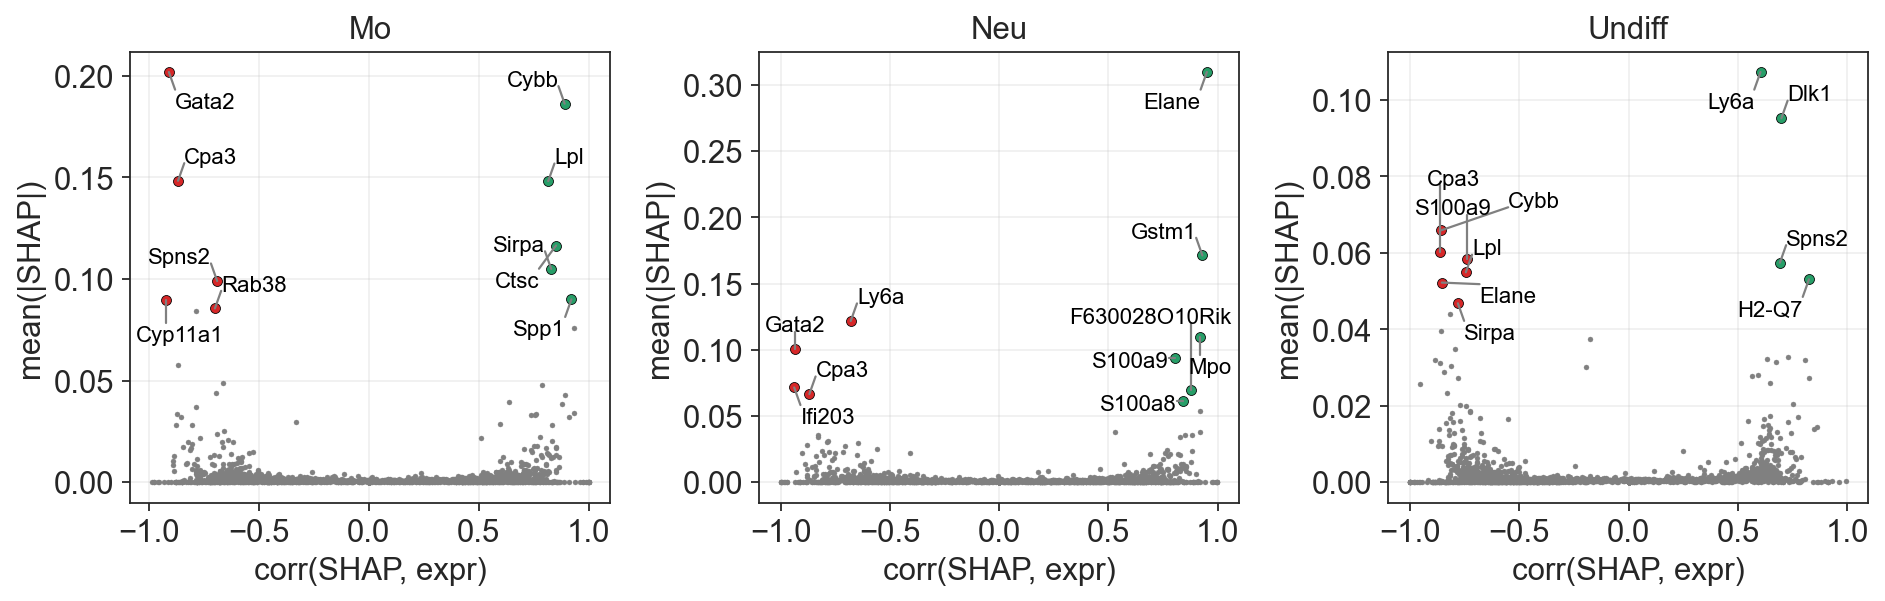

In [149]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for i, ct in enumerate(["Mo", "Neu", "Undiff"]):
    sl.pl.ct_predictors(shapdata_ct, celltype=ct, ax=axes[i])
    
plt.tight_layout()

### Comparison of models

Text(23.752777777777773, 0.5, 'Cell type model $\\overline{|\\mathrm{SHAP}|}$')

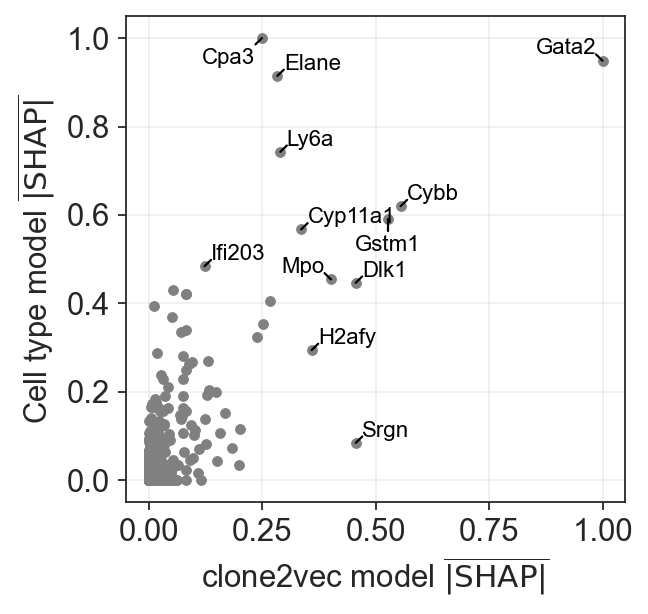

In [128]:
import textalloc as ta

shapdata_ct.var["average_shap_normalized"] = shapdata_ct.var["average_shap"] / shapdata_ct.var["average_shap"].max()

ax = sns.scatterplot(
    x=shapdata_c2v.var["average_shap_normalized"],
    y=shapdata_ct.var["average_shap_normalized"],
    edgecolor=None,
    color="grey",
    s=20,
)

# Plotting genes names
n_genes = 10
genes_ct = shapdata_ct.var["average_shap_normalized"].sort_values()[-n_genes:].index.values
genes_c2v = shapdata_c2v.var["average_shap_normalized"].sort_values()[-n_genes:].index.values

genes = list(set(genes_ct).union(genes_c2v))

ta.allocate(
    ax,
    y=shapdata_ct.var.loc[genes].average_shap_normalized,
    x=shapdata_c2v.var.loc[genes].average_shap_normalized,
    text_list=genes,
    linecolor="black",
)

ax.grid(alpha=0.3)
ax.set_xlabel("clone2vec model $\overline{|\mathrm{SHAP}|}$")
ax.set_ylabel("Cell type model $\overline{|\mathrm{SHAP}|}$")

### Combinational of two models

The main result of the analysis.

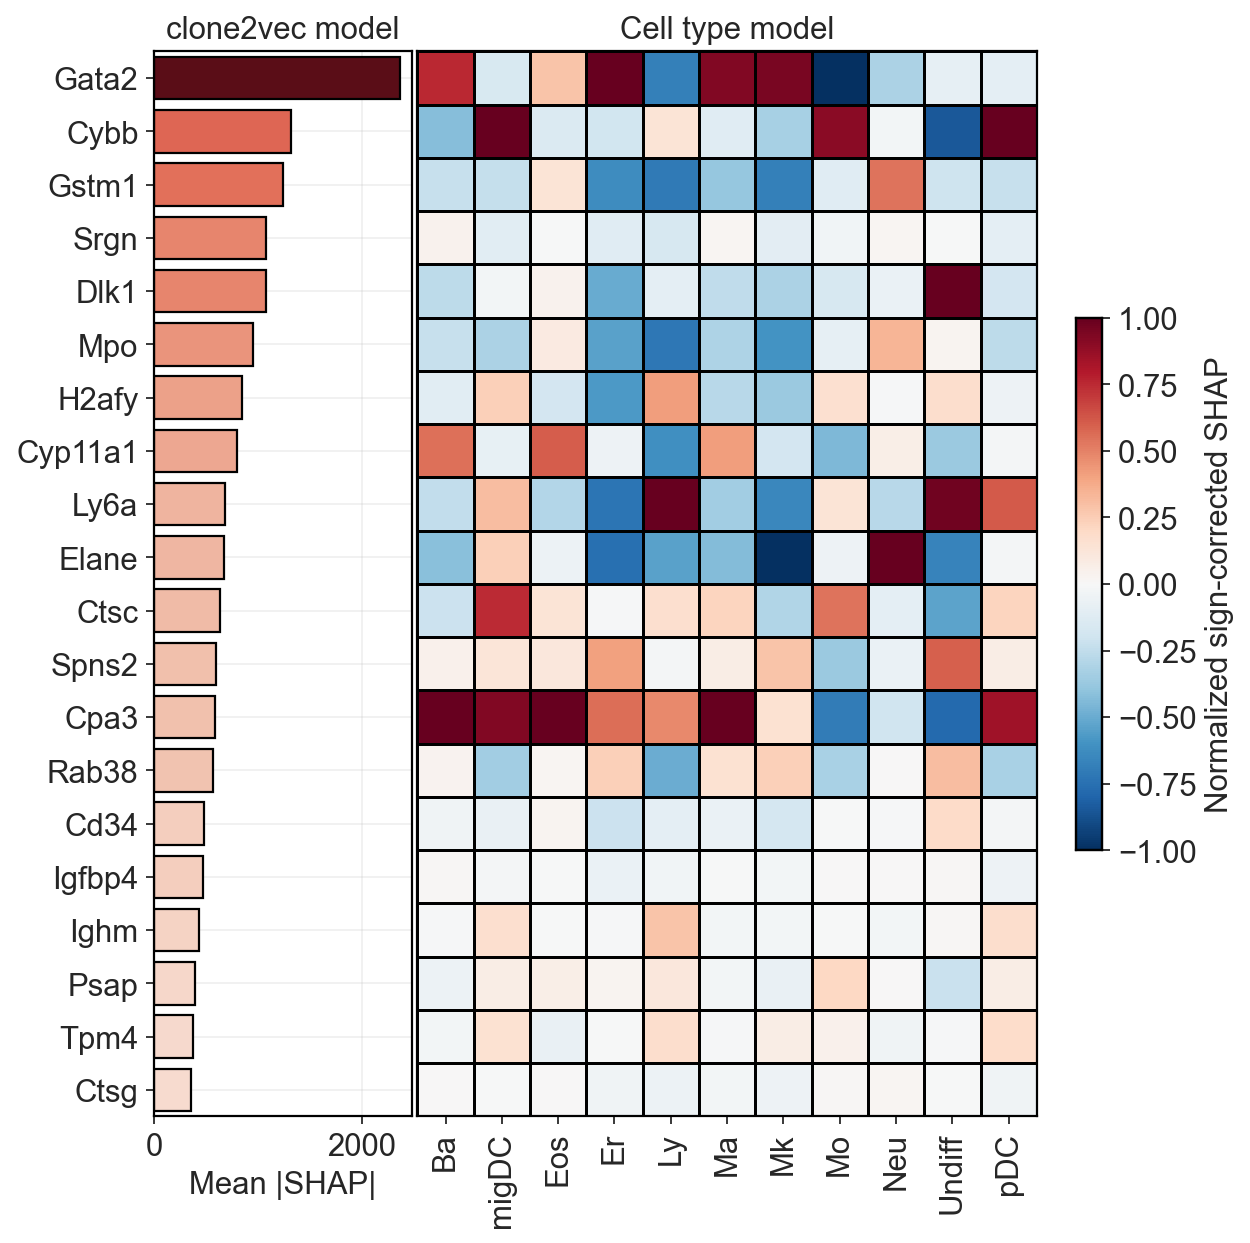

In [167]:
sl.pl.c2v_annotation(shapdata_c2v, shapdata_ct)